# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
holding.round(5)

,Price in USDT,Weights in %
Total,1828.00772,1.00000
BTCUSDT,591.27525,0.32345
TRXUSDT,295.10623,0.16144
JASMYUSDT,257.00940,0.14060
SOLUSDT,243.85835,0.13340
OMUSDT,241.76957,0.13226
ETHUSDT,163.86884,0.08964
BBUSDT,35.09828,0.01920
BNBUSDT,0.02181,0.00001
PEPEUSDT,0.00000,0.00000


In [7]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [8]:
inventory_weights=(holding['Weights in %'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [9]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [10]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions

In [11]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [12]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today(),
                                        startdate=datetime.datetime(2024,5,5))


2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
2024-08-03 00:00:00
2024-09-02 00:00:00
LDUMAUSDT not retrieved
LDTRXUSDT not retrieved
LDUMAUSDT
LDTRXUSDT


In [13]:
positions=positions.sort_index()

In [14]:
positions.index=pd.to_datetime(positions.index)

In [15]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [16]:
positions.to_excel('Positions.xlsx')

In [17]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [18]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [19]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [20]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [21]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [22]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [23]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

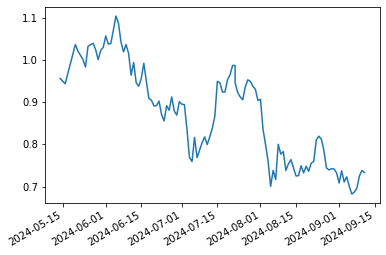

In [24]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [25]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [26]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [27]:
returns_to_use.columns

Index(['1000SATSUSDT', 'AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT',
       'ARUSDT', 'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT',
       'BNXUSDT', 'BONKUSDT', 'BTCUSDT', 'CFXUSDT', 'DOGEUSDT', 'DOTUSDT',
       'EGLDUSDT', 'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT',
       'FILUSDT', 'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT',
       'HBARUSDT', 'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT',
       'LINKUSDT', 'LTCUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT',
       'OPUSDT', 'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SANDUSDT',
       'SEIUSDT', 'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT',
       'TIAUSDT', 'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT',
       'WBTCUSDT', 'WLDUSDT', 'XECUSDT', 'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [28]:
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0]

## Optimal Portfolio

In [29]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory

,Weights
OMUSDT,0.403015
BTCUSDT,0.400000
BNXUSDT,0.196985


In [30]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [31]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current

,Weights
TRXUSDT,0.750422
OMUSDT,0.249578


## Real Portfolio vs Optimal

In [32]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights in %']-current_holding_comparison['Weights']
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,591.275253,3.234534e-01,0.000000,0.000000
TRXUSDT,295.106229,1.614360e-01,0.750422,-0.588986
JASMYUSDT,257.009397,1.405954e-01,0.000000,0.000000
SOLUSDT,243.858350,1.334012e-01,0.000000,0.000000
OMUSDT,241.769569,1.322585e-01,0.249578,-0.117319
ETHUSDT,163.868836,8.964340e-02,0.000000,0.000000
BBUSDT,35.098277,1.920029e-02,0.000000,0.000000
BNBUSDT,0.021809,1.193060e-05,0.000000,0.000000
PEPEUSDT,0.000002,9.728624e-10,0.000000,0.000000


In [33]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights in %']-historical_comparison['Weights']
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,591.275253,3.234534e-01,0.400000,-0.076547
TRXUSDT,295.106229,1.614360e-01,0.000000,0.000000
JASMYUSDT,257.009397,1.405954e-01,0.000000,0.000000
SOLUSDT,243.858350,1.334012e-01,0.000000,0.000000
OMUSDT,241.769569,1.322585e-01,0.403015,-0.270756
ETHUSDT,163.868836,8.964340e-02,0.000000,0.000000
BBUSDT,35.098277,1.920029e-02,0.000000,0.000000
BNBUSDT,0.021809,1.193060e-05,0.000000,0.000000
PEPEUSDT,0.000002,9.728624e-10,0.000000,0.000000
BNXUSDT,0.000000,0.000000e+00,0.196985,0.000000


# Risk Reward Analysis

In [34]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [35]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

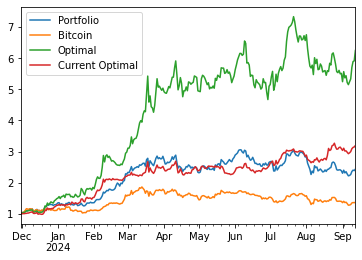

In [36]:
(1+portfolio_perf.iloc[:]).cumprod().plot()

In [37]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

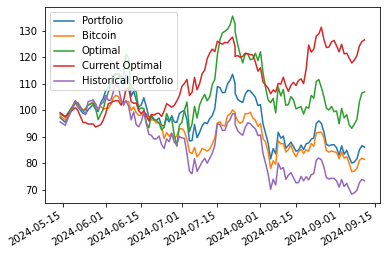

In [38]:
((1+current_perf.iloc[:]).cumprod()*100).plot()

In [39]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-09-02,86.507646,84.205189,100.725496,124.981216,73.774701
2024-09-03,83.382363,81.830358,97.124279,121.350442,71.119955
2024-09-04,84.820154,82.515248,98.350156,121.625503,72.341855
2024-09-05,82.137047,79.925891,94.407299,119.735098,70.104808
2024-09-06,79.995610,76.707855,93.166810,117.925941,68.257851
2024-09-07,80.453537,76.988639,94.745836,119.046088,68.741021
2024-09-08,81.556961,77.990056,96.484267,120.632451,69.673872
2024-09-09,85.023697,81.017786,103.190394,124.379504,72.547158
2024-09-10,86.610897,81.857078,106.568664,125.993546,73.847140
2024-09-11,86.035515,81.432763,106.973390,126.667728,73.353880


<AxesSubplot:>

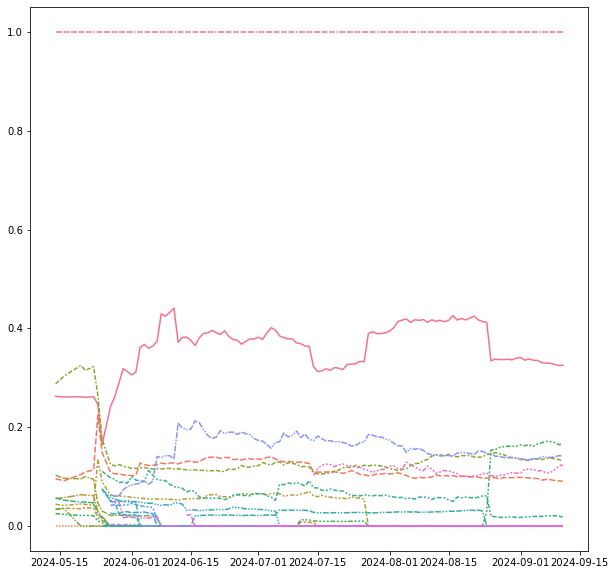

In [40]:
plt.figure(figsize=(10,10))
sns.lineplot(data=weights_ex_post,legend=False,linestyle='solid')

## Volatilities

In [41]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.662329
dtype: float64

In [42]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.488079
dtype: float64

In [43]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.489602
Bitcoin            0.448175
Optimal            0.663451
Current Optimal    0.422548
dtype: float64

In [44]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.2520832185368589

## Risk Contribution

In [45]:
perf_analysis=pd.concat([historical_risk.perf_contrib_pct(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNXUSDT,0.044922,0.061408,0.134179,0.099329,0.034849
BTCUSDT,0.018247,0.059634,0.166233,0.073013,0.093220
OMUSDT,0.936831,0.878958,0.699589,0.609506,0.090082


In [46]:
perf_analysis=pd.concat([current_risk.perf_contrib_pct(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.962426,0.297427,0.256318,0.079513,0.176804
TRXUSDT,-0.755061,0.198624,0.040355,0.011159,0.029195
JASMYUSDT,0.516197,0.126284,0.246753,0.086667,0.160086
SOLUSDT,0.595779,0.112562,0.160526,0.034431,0.126095
OMUSDT,-1.233417,0.186409,0.168798,0.057099,0.111699
ETHUSDT,0.602292,0.070264,0.086458,0.011028,0.075431
BBUSDT,0.311783,0.008430,0.040793,0.003766,0.037028


# Value At Risk

## Historical

In [47]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.055582150805830295, -0.08020452157389985)

In [48]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05036991939252206, -0.06305526139323339)

In [49]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [50]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.011948
TRXUSDT     -0.001762
JASMYUSDT   -0.011330
SOLUSDT     -0.011060
OMUSDT      -0.010822
ETHUSDT     -0.001920
BBUSDT      -0.002048
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.050890
Name: 2024-08-11 00:00:00, dtype: float64

In [51]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.016421
TRXUSDT     -0.003991
JASMYUSDT   -0.014266
SOLUSDT     -0.010323
OMUSDT      -0.010094
ETHUSDT     -0.005842
BBUSDT      -0.002118
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.063055
dtype: float64

## Parametric

In [52]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06874413242826691, -0.08811097107307485)

In [53]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.05057284220683329, -0.06482040109269303)

## Multivariate

In [54]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06235088925763485, -0.07993694555802479)

In [55]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.051448341194993974, -0.0634401348660022)

In [56]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

BTCUSDT     -0.013366
TRXUSDT     -0.002189
JASMYUSDT   -0.011791
SOLUSDT     -0.008362
OMUSDT      -0.008001
ETHUSDT     -0.004350
BBUSDT      -0.002191
Portfolio   -0.050249
dtype: float64

## Copulas

### Gaussian Copula

In [57]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0627765250911275, -0.08071101044805139)

In [58]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.049535325856375365, -0.06374085267381012)

In [59]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.012953
TRXUSDT     -0.001687
JASMYUSDT   -0.011820
SOLUSDT     -0.008324
OMUSDT      -0.008794
ETHUSDT     -0.004585
BBUSDT      -0.002130
Portfolio   -0.050293
dtype: float64

### Student Copula

In [60]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.062277972983989106, -0.07997110909310967)

In [61]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05036457550510552, -0.06463928978265596)

In [62]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.013223
TRXUSDT     -0.001565
JASMYUSDT   -0.012842
SOLUSDT     -0.008072
OMUSDT      -0.008779
ETHUSDT     -0.004509
BBUSDT      -0.002178
Portfolio   -0.051168
dtype: float64

### Gumbel Copula

In [63]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.12469791883693195, -0.1715630739661453)

In [64]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.057305181830533104, -0.07663850786294535)

In [65]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.016702
TRXUSDT     -0.002985
JASMYUSDT   -0.014237
SOLUSDT     -0.008109
OMUSDT      -0.011338
ETHUSDT     -0.003128
BBUSDT       0.000344
Portfolio   -0.056153
dtype: float64

### Monte Carlo

In [66]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [67]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06887326728925977, -0.08535368064105385)

In [68]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05155025691597025, -0.06471662419695347)

In [69]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

BTCUSDT     -0.012673
TRXUSDT     -0.002431
JASMYUSDT   -0.012946
SOLUSDT     -0.007827
OMUSDT      -0.008940
ETHUSDT     -0.004476
BBUSDT      -0.002144
Portfolio   -0.051437
dtype: float64

## VaR Violation

In [70]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.046684,-0.092742,-0.080499,-0.020633
2024-01-15,-0.046684,-0.092739,-0.079276,0.013452
2024-01-16,-0.046684,-0.093280,-0.076177,0.049453
2024-01-17,-0.046684,-0.095046,-0.078440,-0.027654
2024-01-18,-0.046684,-0.096491,-0.082568,-0.025128
...,...,...,...,...
2024-09-08,-0.053927,-0.071448,-0.073805,0.018348
2024-09-09,-0.053927,-0.077026,-0.077589,0.069505
2024-09-10,-0.046573,-0.074354,-0.070035,0.032738
2024-09-11,-0.046573,-0.074357,-0.071624,0.003798


In [71]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.027310,-0.077142,-0.070402,-0.017348
2024-05-29,-0.024355,-0.074666,-0.067423,-0.008517
2024-05-30,-0.024355,-0.064521,-0.058921,0.033622
2024-05-31,-0.024355,-0.063117,-0.057551,0.016759
2024-06-01,-0.024355,-0.063280,-0.054468,0.028210
...,...,...,...,...
2024-09-08,-0.049131,-0.058436,-0.069035,0.013715
2024-09-09,-0.049131,-0.066565,-0.073246,0.042507
2024-09-10,-0.049131,-0.065786,-0.070700,0.018668
2024-09-11,-0.035673,-0.058303,-0.057339,-0.006643


<AxesSubplot:>

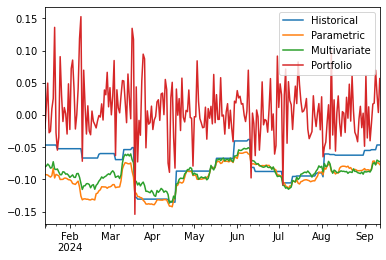

In [72]:
var_data.plot()

<AxesSubplot:>

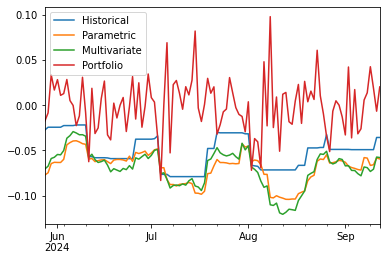

In [73]:
current_var_data.plot()

In [74]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.020576,0.012346,0.00823
Kupiec Stat,5.640289,10.26567,13.523146
P-value,0.017552,0.001355,0.000236


In [75]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.074074,0.037037,0.027778
Kupiec Stat,1.155132,0.41818,1.328988
P-value,0.282477,0.517846,0.248985


## Principal Component Analysis

### Historical PCA

In [76]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.78709132, 0.06489495, 0.05353448, 0.04938469, 0.04509456])

In [77]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

1000SATSUSDT    0.023669
AAVEUSDT        0.014025
ADAUSDT         0.014041
ALGOUSDT        0.015593
APTUSDT         0.014717
                  ...   
WLDUSDT         0.021324
XECUSDT         0.015062
XLMUSDT         0.009514
XRPUSDT         0.009155
XTZUSDT         0.014214
Name: PC1, Length: 66, dtype: float64

<AxesSubplot:>

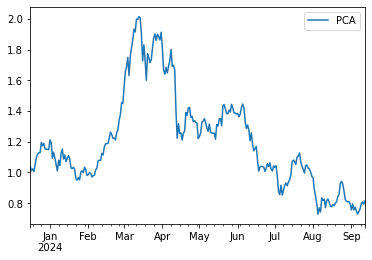

In [78]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

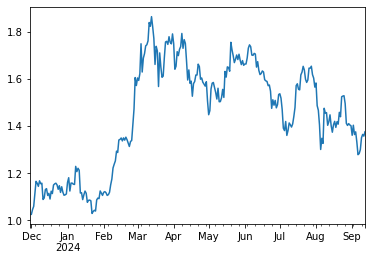

In [79]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [80]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
SANDUSDT     0.299772
XTZUSDT      0.330401
ADAUSDT      0.331449
ALGOUSDT     0.345164
               ...   
PEPEUSDT     0.992314
FLOKIUSDT    1.000881
WLDUSDT      1.021895
BNXUSDT      1.120199
OMUSDT       1.308674
Length: 67, dtype: float64

<AxesSubplot:>

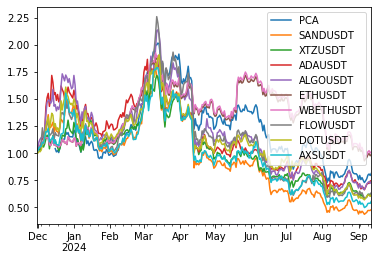

In [81]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

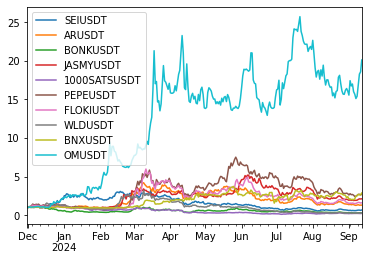

In [82]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

### Current PCA

In [83]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.66884024, 0.14017518, 0.08631707, 0.07224407, 0.03242345])

In [84]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.063462
TRXUSDT      0.015562
JASMYUSDT    0.154628
SOLUSDT      0.103164
OMUSDT       0.102387
ETHUSDT      0.085570
BBUSDT       0.246508
BNBUSDT      0.067999
PEPEUSDT     0.160720
Name: PC1, dtype: float64

<AxesSubplot:>

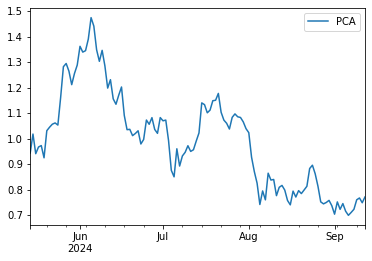

In [85]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

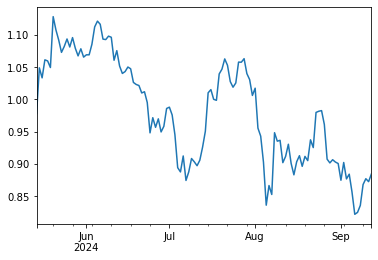

In [86]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [87]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
ETHUSDT      0.326479
SOLUSDT      0.335539
BNBUSDT      0.355939
BTCUSDT      0.358474
JASMYUSDT    0.419978
PEPEUSDT     0.452969
OMUSDT       0.518782
TRXUSDT      0.529919
BBUSDT       0.610283
dtype: float64

<AxesSubplot:>

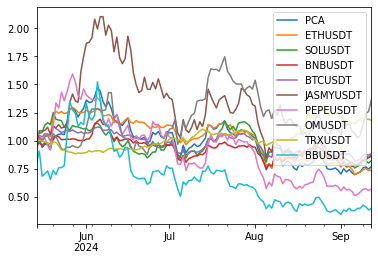

In [88]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [89]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.945413
BBUSDT       1.721370
JASMYUSDT    1.282238
SOLUSDT      1.170002
OMUSDT       1.009021
BTCUSDT      1.000000
ETHUSDT      0.956042
BNBUSDT      0.670928
TRXUSDT      0.286454
Name: BTCUSDT, dtype: float64

In [90]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

OMUSDT       2.023773
PEPEUSDT     1.612477
BBUSDT       1.596791
SOLUSDT      1.311465
ETHUSDT      1.221128
BTCUSDT      1.000000
JASMYUSDT    0.952179
BNBUSDT      0.742888
TRXUSDT      0.244226
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [91]:
results={}
window=7

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,TRXUSDT,JASMYUSDT,SOLUSDT,OMUSDT,ETHUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-20,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-05-27,0.000000,0.000000,0.405921,0.000000,0.000000,0.000000,0.122004,0.000000,0.472076
2024-06-03,0.000000,0.000000,0.185125,0.000000,0.814875,0.000000,0.000000,0.000000,0.000000
2024-06-10,0.000000,0.841078,0.047817,0.000000,0.111105,0.000000,0.000000,0.000000,0.000000
2024-06-17,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.979868,0.000000,0.000000,0.020132,0.000000,0.000000,0.000000,0.000000
2024-07-01,0.000000,0.804372,0.000000,0.146827,0.047122,0.000000,0.001680,0.000000,0.000000
2024-07-08,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
2024-07-15,0.048111,0.606760,0.002957,0.000000,0.000000,0.000000,0.037292,0.304881,0.000000
2024-07-22,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
